In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms 
import torchvision 
import torch.nn as nn
from sklearn.model_selection import train_test_split
import cv2
import os

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Download dataset

In [3]:
!git clone https://github.com/anminhhung/dog-cat-dataset

Cloning into 'dog-cat-dataset'...
remote: Enumerating objects: 25004, done.
remote: Total 25004 (delta 0), reused 0 (delta 0), pack-reused 25004
Receiving objects: 100% (25004/25004), 541.49 MiB | 21.97 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (25001/25001), done.


In [4]:
class DogCatDataset(Dataset):
  def __init__(self, root_dir, transform=None):
    self.list_images_path = []
    self.list_labels = []
    self.one_hot_label = {"dogs": 0, "cats": 1}
    for sub_dir in os.listdir(root_dir):
      path_sub_dir = os.path.join(root_dir, sub_dir)
      for image_name in os.listdir(path_sub_dir):
        image_path = os.path.join(path_sub_dir, image_name)
        label = sub_dir
        self.list_images_path.append(image_path)
        self.list_labels.append(label)
    
    self.transform = transform
  
  def __len__(self):
    return len(self.list_images_path)
  
  def __getitem__(self, idx):
    image = cv2.imread(self.list_images_path[idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = image.astype('float')
    label = np.array(self.one_hot_label[self.list_labels[idx]]).astype('float')

    sample = (image, label)
    if self.transform:
      sample = self.transform(sample)
    
    return sample # image, label

In [5]:
class convertToTensor:
  def __call__(self, sample):
    image, label = sample

    # opencv image: H x W x C
    # torch tensor: C x H x W
    image = torch.from_numpy(image).permute(2, 0, 1).float()
    label = torch.from_numpy(label).long()

    return (image, label)

In [6]:
transformed_train_data = DogCatDataset('dog-cat-dataset/data/train', transform=transforms.Compose([convertToTensor()]))
transformed_test_data = DogCatDataset('dog-cat-dataset/data/test', transform=transforms.Compose([convertToTensor()]))

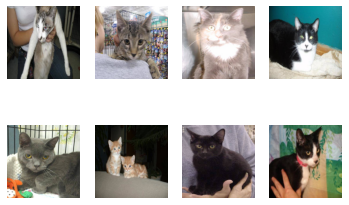

In [7]:
col = 4
row = 2

fig = plt.figure()
for index in range(1, col*row + 1):
  plt.subplot(row, col, index)
  plt.axis('off')
  plt.imshow(cv2.resize(cv2.cvtColor(cv2.imread(transformed_train_data.list_images_path[index]), cv2.COLOR_BGR2RGB), (224, 224)))

In [8]:
train_data_loader = DataLoader(transformed_train_data, batch_size=32, shuffle=True)
test_data_loader = DataLoader(transformed_test_data, batch_size=32, shuffle=True)

# VGG

![image](https://www.researchgate.net/profile/Max-Ferguson/publication/322512435/figure/fig3/AS:697390994567179@1543282378794/Fig-A1-The-standard-VGG-16-network-architecture-as-proposed-in-32-Note-that-only.png)

In [16]:
class VGG16(nn.Module):
    def __init__(self, n_classes=2):
        super(VGG16, self).__init__()

        self.feature_extractor = nn.Sequential(
            self.create_conv_block([3, 64], [64, 64], [3, 3], [1, 1], 2, 2),
            self.create_conv_block([64, 128], [128, 128], [3, 3], [1, 1], 2, 2),
            self.create_conv_block([128, 256, 256], [256, 256, 256], [3, 3, 3], [1, 1, 1], 2, 2),
            self.create_conv_block([256, 512, 512], [512, 512, 512], [3, 3, 3], [1, 1, 1], 2, 2),
            self.create_conv_block([512, 512, 512], [512, 512, 512], [3, 3, 3], [1, 1, 1], 2, 2),
        )

        self.flatten = nn.Flatten() 

        self.FC_layer = nn.Sequential(
            self.create_fc_layer(7*7*512, 1028),
            self.create_fc_layer(1028, 512),
        )

        self.classifier = nn.Linear(in_features=512, out_features=n_classes)
    
    def forward(self, x):
        output = self.feature_extractor(x)
        output = self.flatten(output)
        output = self.FC_layer(output)
        output = self.classifier(output)

        return output

    
    def create_conv_layer(self, chann_in, chann_out, kernel_size, padding_size):
        layer = nn.Sequential(
            nn.Conv2d(chann_in, chann_out, kernel_size=kernel_size, padding=padding_size),
            nn.BatchNorm2d(chann_out),
            nn.ReLU()
        )

        return layer 
    
    def create_conv_block(self, list_chann_in, list_chann_out, list_kernel_size, list_padding_size, pooling_kernel, pooling_Stride):
        layers = [self.create_conv_layer(list_chann_in[i], list_chann_out[i], list_kernel_size[i], list_padding_size[i])
                    for i in range(len(list_chann_in))]
        
        layers += [nn.MaxPool2d(kernel_size=pooling_kernel, stride=pooling_Stride)]

        return nn.Sequential(*layers)
    
    def create_fc_layer(self, chann_in, chann_out):
        layer = nn.Sequential(
            nn.Linear(chann_in, chann_out),
            nn.ReLU()
        )

        return layer 

In [17]:
model = VGG16(2).to(device)

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_function = nn.CrossEntropyLoss()

# Train 

In [19]:
'''
    Function for computing the accuracy of the predictions over the entire data_loader
'''
def get_accuracy(model, data_loader, device):
    correct = 0
    total = 0
    
    with torch.no_grad():
        model.eval()
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100*(correct/total)

'''
    Function for plotting training and validation losses
'''
def plot_losses(train_acc, valid_acc):
    # change the style of the plots to seaborn
    plt.style.use('seaborn')

    train_acc = np.array(train_acc)
    valid_acc = np.array(valid_acc)

    fig, ax = plt.subplots(figsize=(8, 4.5))

    ax.plot(train_acc, color="blue", label="Train_acc")
    ax.plot(valid_acc, color="red", label="Validation_acc")
    ax.set(title="Acc over epochs",
            xlabel="Epoch",
            ylabel="Acc")
    ax.legend()
    fig.show()

  # change the plot style to default
    plt.style.use('default')

'''
    function for the training step of the training loop
'''
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # backward and optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader)

    return model, optimizer, epoch_loss 

'''
    function for the validation step of the training loop
'''
def validate(valid_loader, model, criterion, device):
    model.eval()
    running_loss = 0

    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        # forward pass and record loss
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(valid_loader)

    return model, epoch_loss

'''
    function defining the entire training loop
'''
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    # set object for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    list_train_acc = []
    list_val_acc = []

    # train model
    for epoch in range(0, epochs):
        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)

        if epoch % print_every == print_every - 1:
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)


            print('Epochs: {}, Train_loss: {}, Valid_loss: {}, Train_accuracy: {}, Valid_accuracy: {}'.format(
                    epoch, train_loss, valid_loss, train_acc, valid_acc
                    ))

            list_train_acc.append(train_acc)
            list_val_acc.append(valid_acc)
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)

    plot_losses(list_train_acc, list_val_acc)

    return model, optimizer, (train_losses, valid_losses)

Epochs: 0, Train_loss: 0.5561242331027985, Valid_loss: 0.5369169584884765, Train_accuracy: 74.56, Valid_accuracy: 74.08
Epochs: 1, Train_loss: 0.3917804497361183, Valid_loss: 0.434128939583423, Train_accuracy: 81.77499999999999, Valid_accuracy: 81.06
Epochs: 2, Train_loss: 0.27156651602387427, Valid_loss: 0.21148393606873833, Train_accuracy: 92.07499999999999, Valid_accuracy: 91.16
Epochs: 3, Train_loss: 0.1917681247651577, Valid_loss: 0.3943815085633545, Train_accuracy: 85.34, Valid_accuracy: 84.32
Epochs: 4, Train_loss: 0.14997495947778225, Valid_loss: 0.15591342127911603, Train_accuracy: 95.8, Valid_accuracy: 93.56


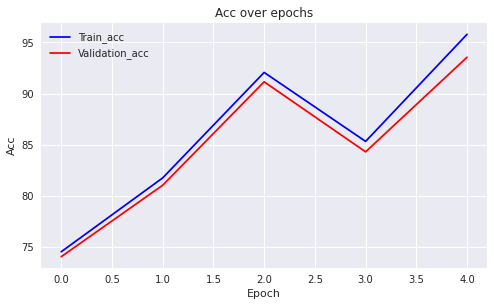

In [20]:
model, optimizer, _ = training_loop(model, loss_function, optimizer, train_data_loader, test_data_loader, 5, device)